<a href="https://colab.research.google.com/github/VMBoehm/pca-classifier/blob/master/ood_data_space_LW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%pylab inline
import os
import pickle
from   sklearn import decomposition, covariance
import numpy as np

Populating the interactive namespace from numpy and matplotlib


Let's do some outlier detection with linear data compression and a Gaussian likelihood!

In [0]:
! pip install git+https://github.com/VMBoehm/pca-classifier

  Cloning https://github.com/VMBoehm/pca-classifier to /tmp/pip-req-build-1oxwe4ht
  Running command git clone -q https://github.com/VMBoehm/pca-classifier /tmp/pip-req-build-1oxwe4ht
  Created wheel for pca-classifier: filename=pca_classifier-0.1.dev39+gaedf1d9-cp36-none-any.whl size=22054 sha256=70fca0f90c3b3791ed2929ac267c4e3216ed179c646f9c271e11cede1966bdce
  Stored in directory: /tmp/pip-ephem-wheel-cache-dz1mc6tc/wheels/b6/92/de/5e335df3a93aac71a83f93369b54139de22ab1656163dab574
Successfully built pca-classifier


In [0]:
from pca_classifier import load_data, prepare_data

In [0]:
mnist_data  = load_data.load_mnist('./')
fmnist_data = load_data.load_fmnist('./')

datasets={}
datasets['fmnist']={}
datasets['mnist']={}
datasets['mnist']['train'] = mnist_data[0]
datasets['fmnist']['train'] = fmnist_data[0]
datasets['mnist']['test'] = mnist_data[2]
datasets['fmnist']['test'] = fmnist_data[2]

masked_datasets_train={}
masked_datasets_test ={}
masked_ood_datasets  ={}

creating  ./mnist


In [0]:
masked_datasets_train['mnist']  = prepare_data.mask_low_var_pixels(datasets['mnist']['train'])
masked_datasets_train['fmnist'] = prepare_data.mask_low_var_pixels(datasets['fmnist']['train'])

masked_datasets_test['mnist']  = prepare_data.mask_low_var_pixels(datasets['mnist']['test'],datasets['mnist']['train'])
masked_datasets_test['fmnist'] = prepare_data.mask_low_var_pixels(datasets['fmnist']['test'],datasets['fmnist']['train'])

#assume it's mnist, but it isn't
masked_ood_datasets['mnist']  = prepare_data.mask_low_var_pixels(datasets['fmnist']['test'],datasets['mnist']['train'])
#assume it's fmnist, but it isn't
masked_ood_datasets['fmnist'] = prepare_data.mask_low_var_pixels(datasets['mnist']['test'],datasets['fmnist']['train'])


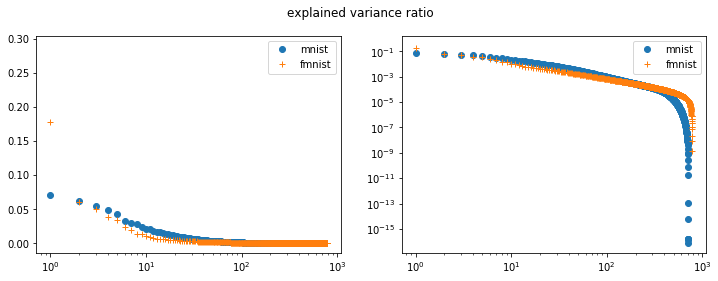

In [0]:
#fit pcas to both datasets

mnist_pcas=[]
fmnist_pcas=[]
recon_noise=[]

for ii, nn in enumerate([8,16,32,-1]):
  if nn ==-1:
    nn=masked_datasets_train['mnist'].shape[-1]
  mnist_pcas+=[decomposition.PCA(n_components=nn)]
  mnist_pcas[ii].fit(masked_datasets_train['mnist'])

for ii, nn in enumerate([8,16,32,-1]):
  if nn ==-1:
    nn=masked_datasets_train['fmnist'].shape[-1]
  fmnist_pcas+=[decomposition.PCA(n_components=nn)]
  fmnist_pcas[ii].fit(masked_datasets_train['fmnist'])

# plot pca components:
plt.figure(figsize=(12,4))
plt.suptitle('explained variance ratio')
plt.subplot(1,2,1)
plt.semilogx(mnist_pcas[-1].explained_variance_ratio_,marker='o',ls='', label='mnist')
plt.plot(fmnist_pcas[-1].explained_variance_ratio_,marker='+',ls='',label='fmnist')
plt.legend()
plt.subplot(1,2,2)
plt.loglog(mnist_pcas[-1].explained_variance_ratio_,marker='o',ls='', label='mnist')
plt.plot(fmnist_pcas[-1].explained_variance_ratio_,marker='+',ls='',label='fmnist')
plt.legend()
plt.show()

In [0]:
from pca_classifier import estimate_covariance as cov_est

OOD in data space

In [0]:
covs  = {}
means = {}
for dataset in ['mnist','fmnist']:
  covs[dataset] = cov_est.CovarianceEstimator(mode='LW')
  covs[dataset].fit(masked_datasets_train[dataset],dataset)
  covs[dataset].decompose()

In [0]:
from pca_classifier.classify import get_covariance, get_log_prob

Use average of unexplained variances as noise estimate

In [0]:
logprobs={}
for dataset in ['mnist','fmnist']:
  logprobs[dataset]={}
  for n_comp in [8,16,32,64,128,-1]:
    if n_comp==-1:
      n_comp=len(masked_datasets_test[dataset][0,:])
    N = np.diag((np.mean((covs[dataset].decompress(covs[dataset].compress(masked_datasets_train[dataset],n_comp))-masked_datasets_train[dataset])**2,axis=0)))
    Cinv, logdetC = get_covariance(covs[dataset].R,covs[dataset].vars,n_comp)
    logprobs[dataset][str(n_comp)] = get_log_prob(logdetC,Cinv,masked_datasets_test[dataset],covs[dataset].mean)

using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error


In [0]:
logprobs_ood={}
for dataset in ['mnist','fmnist']:
  logprobs_ood[dataset]={}
  for n_comp in [8,16,32,64,128,-1]:
    if n_comp==-1:
      n_comp=len(masked_ood_datasets[dataset][0,:])
    N = np.diag((np.mean((covs[dataset].decompress(covs[dataset].compress(masked_datasets_train[dataset],n_comp))-masked_datasets_train[dataset])**2,axis=0)))
    Cinv, logdetC = get_covariance(covs[dataset].R,covs[dataset].vars,n_comp)
    logprobs_ood[dataset][str(n_comp)] = get_log_prob(logdetC,Cinv,masked_ood_datasets[dataset],covs[dataset].mean)

using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error


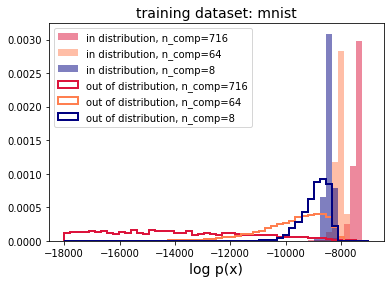

In [0]:
colors = ['crimson','coral','navy','forestgreen']
for dataset in ['mnist']:
  plt.title('training dataset: %s'%dataset, fontsize=14)
  ii=0
  for n_comp in [-1,64,8]:
    if n_comp==-1:
      n_comp=masked_ood_datasets[dataset].shape[-1]
    _, bins, _ = plt.hist(logprobs[dataset][str(n_comp)],bins=50,density=True, label='in distribution, n_comp=%d'%n_comp,color=colors[ii], range=(-18000,-7000),alpha=0.5)
    ii+=1
  ii=0
  for n_comp in [-1,64,8]:
    if n_comp==-1:
      n_comp=masked_ood_datasets[dataset].shape[-1]
    _ = plt.hist(logprobs_ood[dataset][str(n_comp)],histtype='step',bins=50,density=True,label='out of distribution, n_comp=%d'%n_comp, color=colors[ii], range=(-18000,-7000),lw=2)
    ii+=1
  plt.legend()
  plt.xlabel('log p(x)',fontsize=14)
  plt.show()

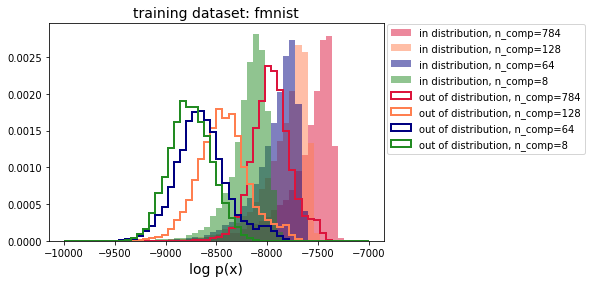

In [0]:
colors = ['crimson','coral','navy','forestgreen']
for dataset in ['fmnist']:
  plt.title('training dataset: %s'%dataset, fontsize=14)
  ii=0
  for n_comp in [-1,128,64,8]:
    if n_comp==-1:
      n_comp=masked_ood_datasets[dataset].shape[-1]
    _, bins, _ = plt.hist(logprobs[dataset][str(n_comp)],bins=50,density=True, label='in distribution, n_comp=%d'%n_comp,color=colors[ii], range=(-10000,-7000),alpha=0.5)
    ii+=1
  ii=0
  for n_comp in [-1,128,64,8]:
    if n_comp==-1:
      n_comp=masked_ood_datasets[dataset].shape[-1]
    _ = plt.hist(logprobs_ood[dataset][str(n_comp)],histtype='step',bins=50,density=True,label='out of distribution, n_comp=%d'%n_comp, color=colors[ii], range=(-10000,-7000),lw=2)
    ii+=1
  plt.legend(loc=(1.01,0.4))
  plt.xlabel('log p(x)',fontsize=14)
  plt.show()

In [0]:
logprobs={}
for dataset in ['mnist','fmnist']:
  logprobs[dataset]={}
  for n_comp in [8,16,32,64,128,-1]:
    if n_comp==-1:
      n_comp=len(masked_datasets_test[dataset][0,:])
    N = np.diag((np.mean((covs[dataset].decompress(covs[dataset].compress(masked_datasets_train[dataset],n_comp))-masked_datasets_train[dataset])**2,axis=0)))
    Cinv, logdetC = get_covariance(covs[dataset].R,covs[dataset].vars,n_comp,N=N)
    logprobs[dataset][str(n_comp)] = get_log_prob(logdetC,Cinv,masked_datasets_test[dataset],covs[dataset].mean)

In [0]:
logprobs_ood={}
for dataset in ['mnist','fmnist']:
  logprobs_ood[dataset]={}
  for n_comp in [8,16,32,64,128,-1]:
    if n_comp==-1:
      n_comp=len(masked_ood_datasets[dataset][0,:])
    N = np.diag((np.mean((covs[dataset].decompress(covs[dataset].compress(masked_datasets_train[dataset],n_comp))-masked_datasets_train[dataset])**2,axis=0)))
    Cinv, logdetC = get_covariance(covs[dataset].R,covs[dataset].vars,n_comp,N=N)
    logprobs_ood[dataset][str(n_comp)] = get_log_prob(logdetC,Cinv,masked_ood_datasets[dataset],covs[dataset].mean)

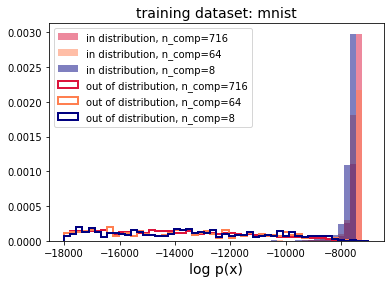

In [0]:
colors = ['crimson','coral','navy','forestgreen']
for dataset in ['mnist']:
  plt.title('training dataset: %s'%dataset, fontsize=14)
  ii=0
  for n_comp in [-1,64,8]:
    if n_comp==-1:
      n_comp=masked_ood_datasets[dataset].shape[-1]
    _, bins, _ = plt.hist(logprobs[dataset][str(n_comp)],bins=50,density=True, label='in distribution, n_comp=%d'%n_comp,color=colors[ii], range=(-18000,-7000),alpha=0.5)
    ii+=1
  ii=0
  for n_comp in [-1,64,8]:
    if n_comp==-1:
      n_comp=masked_ood_datasets[dataset].shape[-1]
    _ = plt.hist(logprobs_ood[dataset][str(n_comp)],histtype='step',bins=50,density=True,label='out of distribution, n_comp=%d'%n_comp, color=colors[ii], range=(-18000,-7000),lw=2)
    ii+=1
  plt.legend()
  plt.xlabel('log p(x)',fontsize=14)
  plt.show()

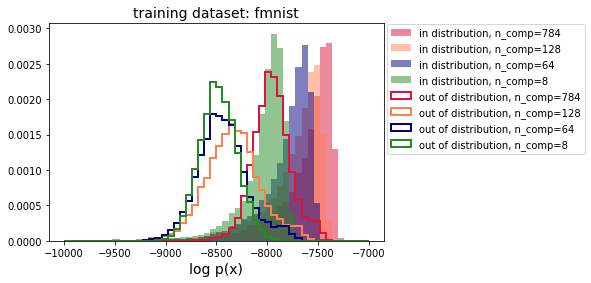

In [0]:
colors = ['crimson','coral','navy','forestgreen']
for dataset in ['fmnist']:
  plt.title('training dataset: %s'%dataset, fontsize=14)
  ii=0
  for n_comp in [-1,128,64,8]:
    if n_comp==-1:
      n_comp=masked_ood_datasets[dataset].shape[-1]
    _, bins, _ = plt.hist(logprobs[dataset][str(n_comp)],bins=50,density=True, label='in distribution, n_comp=%d'%n_comp,color=colors[ii], range=(-10000,-7000),alpha=0.5)
    ii+=1
  ii=0
  for n_comp in [-1,128,64,8]:
    if n_comp==-1:
      n_comp=masked_ood_datasets[dataset].shape[-1]
    _ = plt.hist(logprobs_ood[dataset][str(n_comp)],histtype='step',bins=50,density=True,label='out of distribution, n_comp=%d'%n_comp, color=colors[ii], range=(-10000,-7000),lw=2)
    ii+=1
  plt.legend(loc=(1.01,0.4))
  plt.xlabel('log p(x)',fontsize=14)
  plt.show()

OOD in compressed space

In [0]:
def get_comp_log_prob(d,cov,n_comp):
  s = cov.compress(d,n_comp)
  S = cov.vars[:n_comp]
  S_inv = 1./S
  logdetS = np.sum(np.log(S))
  result = -0.5*(np.einsum('ij,j,ij->i',s,S_inv,s,optimize=True)+n_comp*np.log(2*np.pi)+logdetS)

  return result

In [0]:
logprobs={}
for dataset in ['mnist','fmnist']:
  logprobs[dataset]={}
  for n_comp in [16,32,64,128]:
    if n_comp==-1:
      n_comp=len(masked_datasets_test[dataset][0,:])
    logprobs[dataset][str(n_comp)] = get_comp_log_prob(masked_datasets_test[dataset],covs[dataset],n_comp)

In [0]:
logprobs_ood={}
for dataset in ['mnist','fmnist']:
  logprobs_ood[dataset]={}
  for n_comp in [16,32,64,128]:
    if n_comp==-1:
      n_comp=len(masked_ood_datasets[dataset][0,:])
    logprobs_ood[dataset][str(n_comp)] = get_comp_log_prob(masked_ood_datasets[dataset],covs[dataset],n_comp)

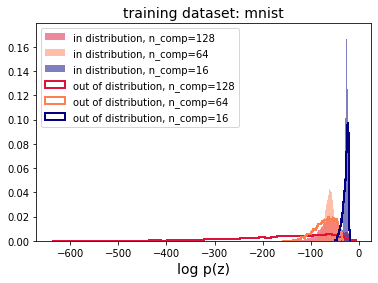

In [0]:
colors = ['crimson','coral','navy']
for dataset in ['mnist']:
  plt.title('training dataset: %s'%dataset, fontsize=14)
  ii=0
  for n_comp in [128,64,16]:
    if n_comp==-1:
      n_comp=masked_ood_datasets[dataset].shape[-1]
    _, bins, _ = plt.hist(logprobs[dataset][str(n_comp)],bins=50,density=True, label='in distribution, n_comp=%d'%n_comp,color=colors[ii],alpha=0.5)
    ii+=1
  ii=0
  for n_comp in [128,64,16]:
    if n_comp==-1:
      n_comp=masked_ood_datasets[dataset].shape[-1]
    _ = plt.hist(logprobs_ood[dataset][str(n_comp)],histtype='step',bins=50,density=True,label='out of distribution, n_comp=%d'%n_comp, color=colors[ii],lw=2)
    ii+=1
  plt.legend()
  plt.xlabel('log p(z)',fontsize=14)
  plt.show()

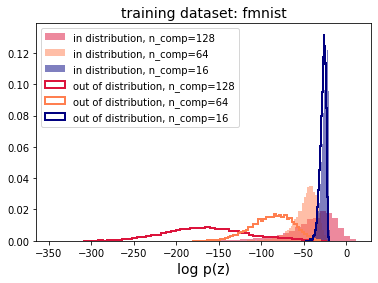

In [0]:
colors = ['crimson','coral','navy']
for dataset in ['fmnist']:
  plt.title('training dataset: %s'%dataset, fontsize=14)
  ii=0
  for n_comp in [128,64,16]:
    if n_comp==-1:
      n_comp=masked_ood_datasets[dataset].shape[-1]
    _, bins, _ = plt.hist(logprobs[dataset][str(n_comp)],bins=50,density=True, label='in distribution, n_comp=%d'%n_comp,color=colors[ii],alpha=0.5)
    ii+=1
  ii=0
  for n_comp in [128,64,16]:
    if n_comp==-1:
      n_comp=masked_ood_datasets[dataset].shape[-1]
    _ = plt.hist(logprobs_ood[dataset][str(n_comp)],histtype='step',bins=50,density=True,label='out of distribution, n_comp=%d'%n_comp, color=colors[ii],lw=2)
    ii+=1
  plt.legend()
  plt.xlabel('log p(z)',fontsize=14)
  plt.show()